In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import daspi as dsp
import numpy as np
import pandas as pd
import matplotlib as mpl

from scipy import stats
from typing import Any
from typing import Dict
DPI = 120
dsp.__version__

'1.3.0'

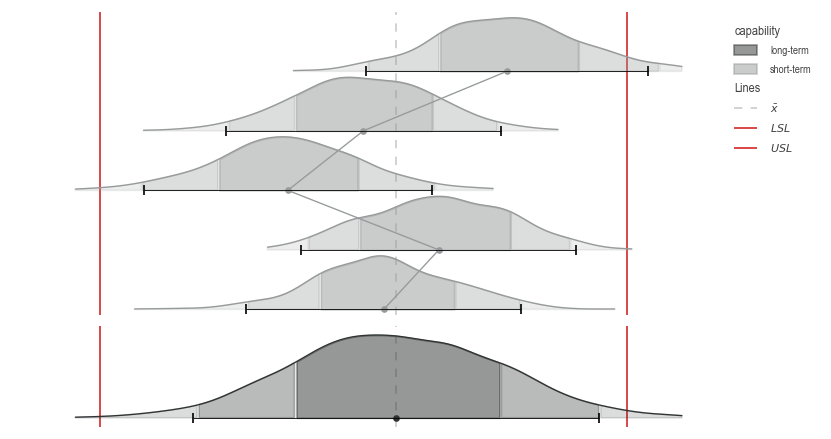

In [2]:
np.random.seed(3)
N_SAMPLES = 500
HEIGHT = 0.9
means = np.random.random(5)-0.5
df_batch = pd.DataFrame()

for i, mean in enumerate(means):
    pos = i
    data = pd.DataFrame({
        'capability': 'short-term',
        'position': pos,
        'values': stats.norm.rvs(size=N_SAMPLES, loc=mean, scale=0.2)})
    df_batch = pd.concat([df_batch, data], axis=0, ignore_index=True)
df_tot = pd.DataFrame({
    'capability': 'long-term',
    'position': 0,
    'mean': '0',
    'values': df_batch['values']})

chart = dsp.JointChart(
        source=pd.concat([df_batch, df_tot]),
        target='values',
        feature='position',
        hue='capability',
        ncols=1,
        nrows=2,
        height_ratios=[3, 1],
        target_on_y=False,
        sharex=True,
        sharey=False,
        colors=(dsp.DEFAULT.PLOTTING_COLOR, '#979A9A')
    ).stripes(
        stripes=[dsp.StripeLine(
            r'\bar x', df_tot['values'].mean(), orientation='vertical')],
        spec_limits=(-0.75, 0.75),
    ).label(
    )

hueing = chart.charts[0].hueing

def axes_settings(ax) -> None:
    ax.xaxis.set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set(ylim=(-0.1, None), xlim=(-1, 1))

kw_base: Dict[str, Any] = dict(
    feature='position',
    target='values',
    target_on_y=False,
    ax=chart.axes[0, 0],
    color=hueing.categories[1])
kw_kde: Dict[str, Any] = dict(
    height=HEIGHT,
    fill=True,
    ignore_feature=False)
kw_spread: Dict[str, Any] = dict(
    marker='o',
    agreement=4,
)
dsp.CenterLocation(source=df_batch, show_center=False, **kw_base)()
for pos, group in df_batch.groupby('position'):
    dsp.GaussianKDE(source=group, f_base=pos, **(kw_base | kw_kde))()
    dsp.SpreadWidth(source=group, **(kw_base | kw_spread))()

kw_base['ax'] = chart.axes[1, 0]
kw_base['color'] = hueing.categories[0]
dsp.GaussianKDE(source=df_tot, f_base=0, **(kw_base | kw_kde))()
dsp.SpreadWidth(source=df_tot, **(kw_base | kw_spread))()

for ax in chart.axes.flat:
    axes_settings(ax)

In [3]:
pos, data = next(iter(df_batch.groupby('position')))
estimation = dsp.ProcessEstimator(data['values'], -0.75, 0.75)
estimation.Z_lt

2.0395762631892227

In [4]:
estimation = dsp.ProcessEstimator(df_tot['values'], -0.75, 0.75)
estimation.Z

2.281028062704287

,distance
n_samples,40
n_missing,0
n_ok,38
n_nok,2
n_errors,0
ok,95.00 %
nok,5.00 %
nok_pred,4.16 %
min,8.5
max,83.0


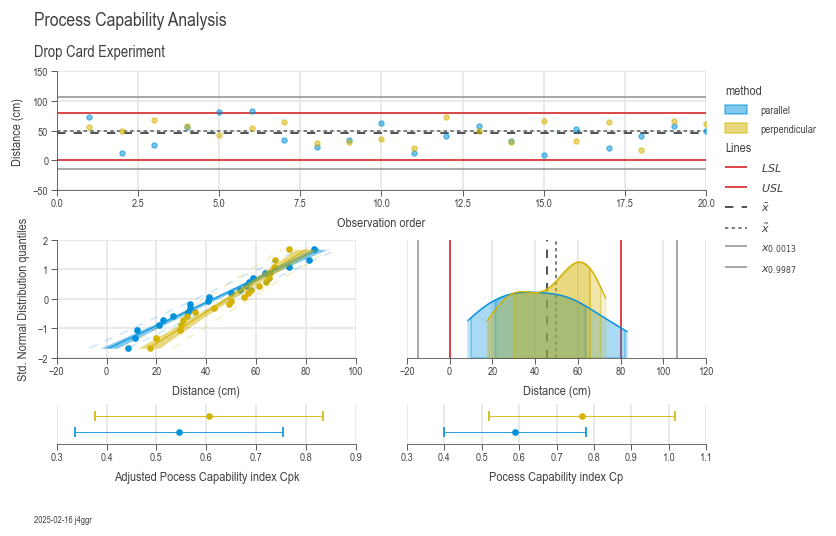

In [5]:
import daspi as dsp

df = dsp.load_dataset('drop_card')
spec_limits = 0, float(df.loc[0, 'usl'])
target = 'distance'

chart = dsp.ProcessCapabilityAnalysisCharts(
        source=df,
        target=target,
        spec_limits=spec_limits,
        hue='method'
    ).plot(
    ).stripes(
    ).label(
        fig_title='Process Capability Analysis',
        sub_title='Drop Card Experiment',
        target_label='Distance (cm)',
        info=True)
distance = dsp.ProcessEstimator(
    samples=df[target],
    lsl=spec_limits[0],
    usl=spec_limits[1])
distance.describe()

ASS temperature: logistic
Godamed temperature: gamma
ASS dissolution: foldnorm
Godamed dissolution: norm


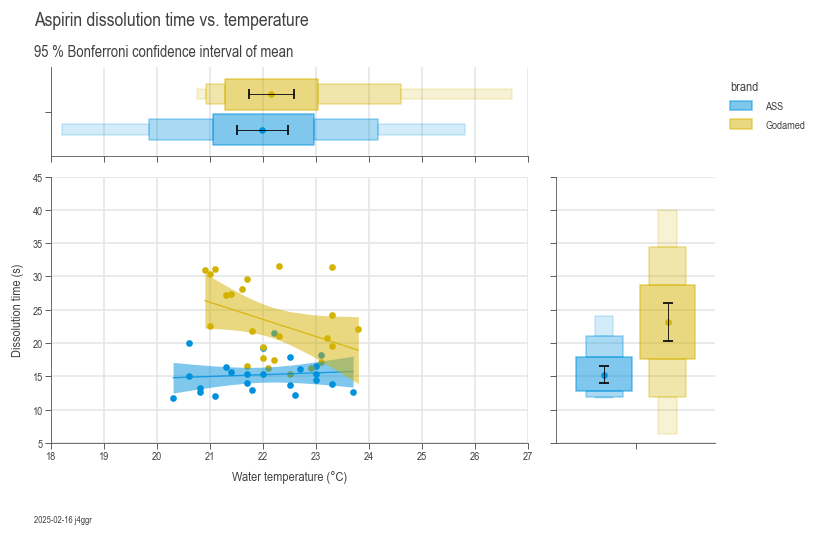

In [6]:
import daspi as dsp

df = dsp.load_dataset('aspirin-dissolution')
hue = 'brand'
n_groups = df.groupby(hue).ngroups
chart = dsp.BivariateUnivariateCharts(
        source=df,
        target='dissolution',
        feature='temperature',
        hue=hue,
        dodge_univariates=True,
    ).plot_univariates(
        dsp.MeanTest, n_groups=n_groups
    ).plot_univariates(
        dsp.QuantileBoxes, strategy='fit'
    ).plot_bivariate(
        dsp.LinearRegressionLine, show_fit_ci=True
    ).label(
        fig_title='Aspirin dissolution time vs. temperature',
        sub_title='95 % Bonferroni confidence interval of mean',
        feature_label='Water temperature (°C)',
        target_label='Dissolution time (s)',
        info=True
    )

brands = (brand for brand in df[hue].unique().tolist()*2)
for plot in chart.plots:
    if isinstance(plot, dsp.QuantileBoxes):
        print(f'{next(brands)} {plot.target}: {plot.estimation.dist.name}')

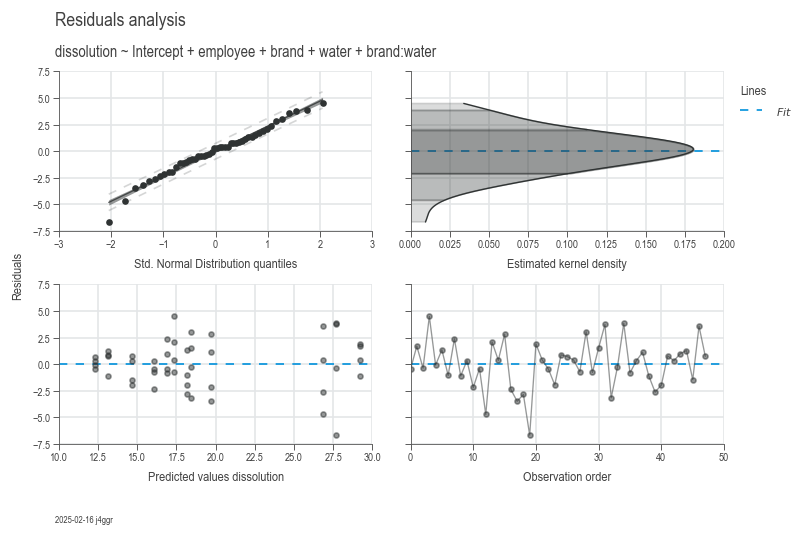

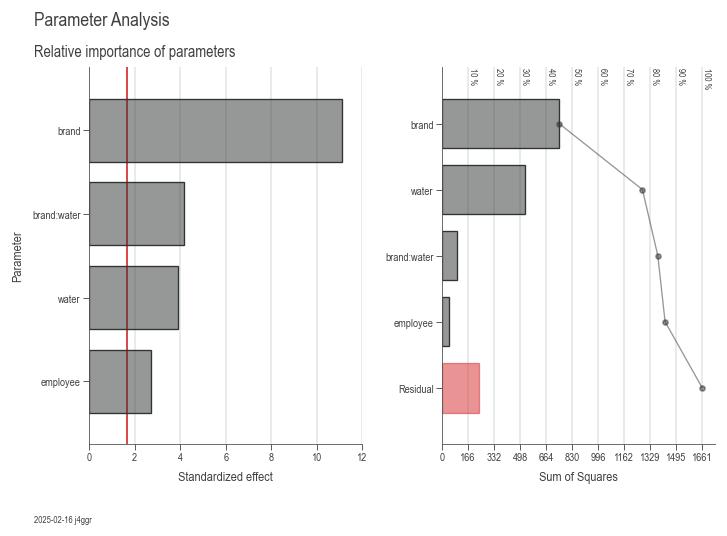

In [18]:
import daspi as dsp

df = dsp.load_dataset('aspirin-dissolution')
model = dsp.LinearModel(
    source=df,
    target='dissolution',
    features=['employee', 'stirrer', 'brand', 'catalyst', 'water'],
    disturbances=['temperature', 'preparation'],
    order=2)
df_gof = pd.DataFrame()
for data_gof in model.recursive_elimination():
    df_gof = pd.concat([df_gof, data_gof])

dsp.ResidualsCharts(model).plot().stripes().label(info=True)
dsp.ParameterRelevanceCharts(model).plot().label(info=True)

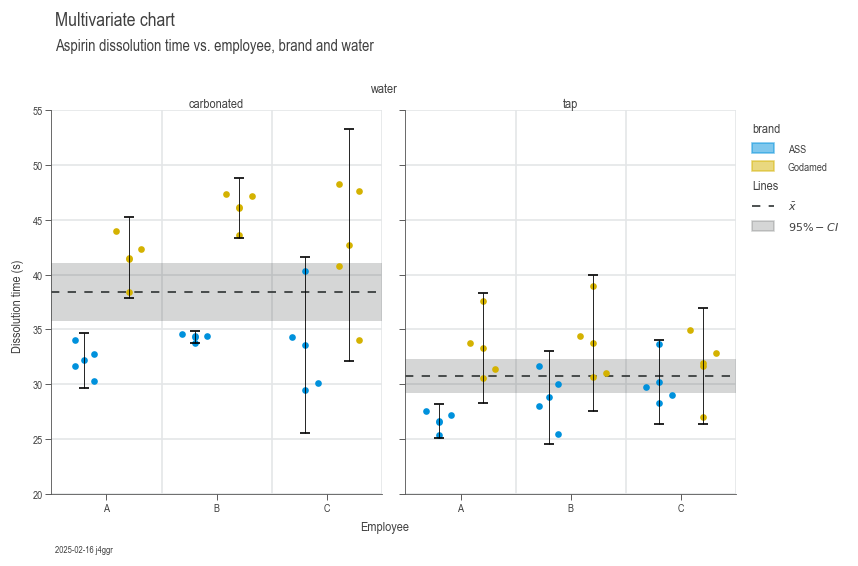

In [21]:
dsp.MultivariateChart(
        source=df,
        target='time',
        feature='employee',
        hue='brand',
        col='water',
        dodge=True
    ).plot(
        dsp.MeanTest, n_groups=1,
    ).plot(
        dsp.Beeswarm,
    ).stripes(
        mean=True,
        confidence=0.95
    ).label(
        fig_title='Multivariate chart',
        sub_title='Aspirin dissolution time vs. employee, brand and water',
        target_label='Dissolution time (s)',
        feature_label='Employee',
        info=True
    )